# KNN on Barcode Distances

Following https://towardsdatascience.com/create-your-own-k-nearest-neighbors-algorithm-in-python-eb7093fc6339

For the KNN the X-values consists of indices (ids) of simulations and the Y-values are labels (Moon, Mars).

 - `X` consists of names of simulations. 
 - `distance_matrix_function` is a function wrapping up the distance matrix data, where rows and columns are 
    labeled by simulation name.

In [1]:
from os_utilities import *
from zz_persistence import *

from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
year = 2024

folder_name = "sim-2023-02-12-{}-rnd".format(year)
# folder_name = "sim-2023-02-12-rnd"
folder = "./outputs/" + folder_name
# folder = "/home/zeno/Documents/repositories/nasa-2022/satParsing/outputs/sim-2023-01-25-2016-fst"
# folder = "/home/zeno/Documents/repositories/nasa-2022/satParsing/outputs/sim-2023-01-25-2018-rnd"

folder_stats = folder + "-stats"
make_folder(folder_stats)

MOON = 0
MARS = 1

# generate x, y
x = []
y = []

# get all contact analysis data from simulation folder.
diagrams = {}
# diagrams_clique = {}

counter = 0
filepaths = get_csv_files(folder)

csv_filepaths = []

for filepath in filepaths:
    if not filepath.endswith("Contact Analysis.csv"):
        continue
    else:
        counter += 1
        csv_filepaths.append(filepath)
        # print(counter)
        
    
for filepath in csv_filepaths:
    

    contact_plan = ca.contact_analysis_parser(filepath)
    graph = ca.construct_graph(contact_plan)    
    weighted_simplex = ca.construct_weighted_simplex(graph)
    # clique_complex = ca.construct_clique_complex(graph)

    # print(filepath)
    simplex = weighted_simplex["simplex"]
    times = weighted_simplex["times"]
    for i in range(len(simplex)):
        # print("simplex = {}; times = {}".format(simplex[i], times[i]))
        t_prev = -1
        for t in times[i]:
            if t <= t_prev or (t - t_prev) < 1:
                print("ERROR")
            t_prev = t
    
    # break
    
    zz, dgms, cells = calculate_zz_persistence(weighted_simplex)
    # zz_clique, dgms_clique, cells_clique = calculate_zz_persistence(clique_complex)
    
    filename = filepath.split("/")[-1]
    
    diagrams[filename] = {
        "dgms" : dgms,
        "id" : len(x)
    }
    # diagrams_clique[filename] = dgms_clique
    
    x.append(filename)
    label = -1
    if "moon" in filename:
        label = MOON
    elif "mars" in filename:
        label = MARS

    y.append(label)

# print(diagrams)

## Construct Distance Matrix Function

In [3]:
def distance_matrix(diagrams, x, y, dim = 0):
    m = len(diagrams)
    matrix = np.zeros((m, m))
    
    for i in range(m):
        diagram_i = diagrams[x[i]]["dgms"]
        for j in range(i + 1, m):
            diagram_j = diagrams[x[j]]["dgms"]
            # distance_ij = d.bottleneck_distance(diagram_i[dim], diagram_j[dim])
            distance_ij = d.wasserstein_distance(diagram_i[dim], diagram_j[dim], q = 2)
            matrix[i, j] = distance_ij
            matrix[j, i] = distance_ij
            # print("{}, {}".format(i, j))
    # print(matrix)
    return lambda a, b : matrix[diagrams[a]["id"]][diagrams[b]["id"]]
    
dim = 1
distance_matrix_function = distance_matrix(diagrams, x, y, dim = dim)

# print(distance_matrix_function("emm_mars_3 Contact Analysis.csv", "emm_mars_4 Contact Analysis.csv"))

## Create Distance Matrix

In [4]:
m = len(diagrams)
distance_matrix = []
for i in range(m):
    row = []
    for j in range(m):
        row.append(distance_matrix_function(x[i], x[j]))
    distance_matrix.append(row)
    
distance_matrix = np.array(distance_matrix)
# print(distance_matrix)

## Prepare train / test data

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## Custom KNN Code

In [6]:
def most_common(lst):
    '''Returns the most common element in a list'''
    return max(set(lst), key=lst.count)

class KNeighborsClassifier():
    
    def __init__(self, dist_matrix_function, k=5):
        self.k = k
        self.dist_metric = dist_matrix_function   
        
    def fit(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train
        
    def predict(self, x_test):
        neighbors = []
        for x in x_test:
            distances = [self.dist_metric(x, i) for i in self.x_train]
            y_sorted = [y for _, y in sorted(zip(distances, self.y_train))]
            neighbors.append(y_sorted[:self.k])        
        return list(map(most_common, neighbors))
    
    def evaluate(self, x_test, y_test):
        y_pred = self.predict(x_test)
        sum_equals = 0
        for i in range(len(x_test)):
            if y_pred[i] == y_test[i]:
                sum_equals += 1
        accuracy = sum_equals / len(y_test)
        return accuracy

## Run KNN


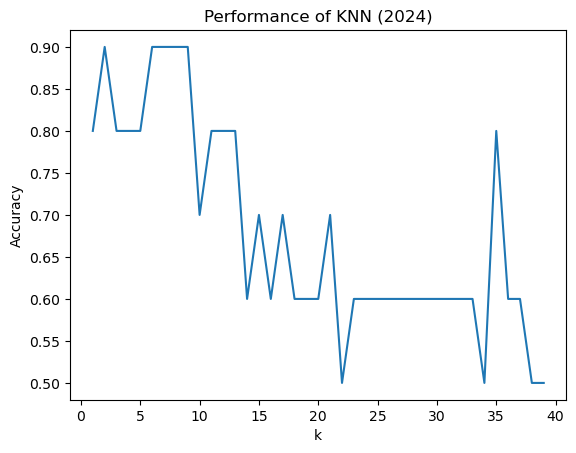

In [7]:
accuracies = []
ks = range(1, 40)
for k in ks:
    knn = KNeighborsClassifier(distance_matrix_function, k=k)
    knn.fit(x_train, y_train)
    accuracy = knn.evaluate(x_test, y_test)
    accuracies.append(accuracy)
    
fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="k",
       ylabel="Accuracy",
       title="Performance of KNN ({})".format(year))
plt.savefig(folder_stats + "/knn-{}.png".format(year))
plt.show()


In [8]:
m = 200
# k = 6
for k in range(1, 10):
    accuracies = []
    for i in range(m):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        knn = KNeighborsClassifier(distance_matrix_function, k=k)
        knn.fit(x_train, y_train)
        accuracy = knn.evaluate(x_test, y_test)
        accuracies.append(accuracy)

    average = sum(accuracies) / len(accuracies)
    print("Average out of {} train/test splits is {} for k = {} with dim = {}".format(m, average, k, dim))

Average out of 200 train/test splits is 0.6624999999999998 for k = 1 with dim = 1
Average out of 200 train/test splits is 0.6194999999999997 for k = 2 with dim = 1
Average out of 200 train/test splits is 0.6724999999999998 for k = 3 with dim = 1
Average out of 200 train/test splits is 0.6315 for k = 4 with dim = 1
Average out of 200 train/test splits is 0.6429999999999998 for k = 5 with dim = 1
Average out of 200 train/test splits is 0.6415000000000003 for k = 6 with dim = 1
Average out of 200 train/test splits is 0.6325 for k = 7 with dim = 1
Average out of 200 train/test splits is 0.6374999999999996 for k = 8 with dim = 1
Average out of 200 train/test splits is 0.6639999999999996 for k = 9 with dim = 1


In [9]:
# from ripser import ripser
# from persim import plot_diagrams

# results = ripser(distance_matrix, distance_matrix=True)
# fig, ax = plt.subplots(1, figsize=(8, 6))
# plot_diagrams(results['dgms'], show=False)
# plt.show()

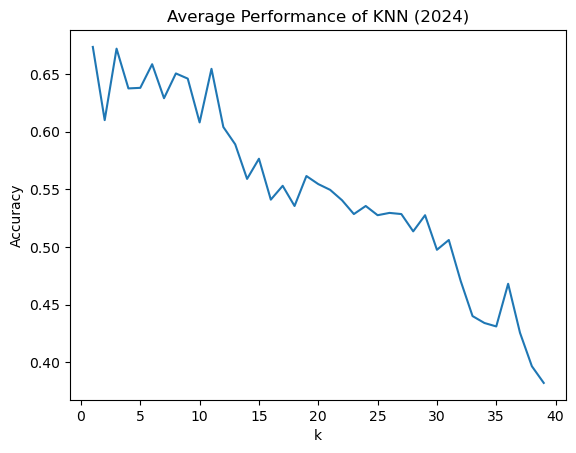

In [10]:
m = 200
accuracies = []

ks = range(1, 40)
for k in ks:
    k_accuracies = []
    for i in range(m):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        knn = KNeighborsClassifier(distance_matrix_function, k=k)
        knn.fit(x_train, y_train)
        accuracy = knn.evaluate(x_test, y_test)
        k_accuracies.append(accuracy)
    average = sum(k_accuracies) / len(k_accuracies)
    accuracies.append(average)
    
fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="k",
       ylabel="Accuracy",
       title="Average Performance of KNN ({})".format(year))
plt.savefig(folder_stats + "/knn-{}-average.png".format(year))
plt.show()